# Quantum Circuits
Quantum computers can only use a specific set of gates (universal gate set). Given the entanglers and their amplitudes found in Step 3, one can find corresponding representation of these operators in terms of elementary gates using the following procedure.

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

import tequila as tq
from utility import *

In [41]:
def get_qubit_hamiltonian2(mol, geometry, basis, charge=0, multiplicity=1, qubit_transf='jw'):
    '''
    Generating qubit hamiltonina of the given molecules with specified geometry, basis sets, charge and multiplicity
    Give its qubit form using specified transformation
    '''
    g = get_molecular_data(mol, geometry)
    mol = MolecularData(g, basis, multiplicity, charge)
    mol = run_pyscf(mol)
    ham = mol.get_molecular_hamiltonian()    
    hamf = get_fermion_operator(ham)
    
    
    if qubit_transf == 'bk':
        hamq = bravyi_kitaev(hamf)
    elif qubit_transf == 'jw':
        hamq = jordan_wigner(hamf)
    else:
        raise(ValueError(qubit_transf, 'Unknown transformation specified'))

    return remove_complex(hamq)


In [42]:
from openfermion.ops import FermionOperator

In [43]:
def createHam(h, n_qubits = None):

    I, X, Y, Z = np.identity(2), np.array([[0, 1], [1, 0]]), np.array([[0, -1j], [1j, 0]]), np.array([[1, 0], [0, -1]])

    # Build matrix representiation of the Hamiltonian H
    if(n_qubits is None):
        n_qubits = openfermion.count_qubits(h)
        #print(n_qubits)
    
    h_matrix = np.zeros((2**n_qubits, 2**n_qubits), dtype=np.complex)
    for term, term_coeff in h.terms.items(): # Iterate over pauli-words of H
        term = dict(term) # Dict[qubit_index, 'X'/'Y'/'Z']

        # Build matrix rep of current pauli-word using kronecker product to represent x_i y_j ...
        pw_matrix = np.identity(1)
        for i in range(n_qubits):
            if i not in term:        pw_matrix = np.kron(pw_matrix, I)
            else:
                if term[i] == 'X':   pw_matrix = np.kron(pw_matrix, X)
                elif term[i] == 'Y': pw_matrix = np.kron(pw_matrix, Y)
                else:                pw_matrix = np.kron(pw_matrix, Z)
        h_matrix += pw_matrix * term_coeff

    return h_matrix

First, we set up the Hamiltonian in Tequila's format and the unitary gates obtained in Step 3. 

In [67]:
ham = get_qubit_hamiltonian2('h2', 2, 'sto-3g', qubit_transf='jw')
H = tq.QubitHamiltonian.from_openfermion(ham)

## Particle projector in Second Quantization is not a fun operator

In [154]:
mol = 'h2'
g = get_molecular_data(mol, 0.741)
mol = MolecularData(g, 'sto3g', 1, 0)
mol = run_pyscf(mol)
ham = mol.get_molecular_hamiltonian()    
hamf = get_fermion_operator(ham)


xyz_data = get_molecular_data('h2', geometry=0.741, xyz_format=True)
hmol = tq.quantumchemistry.Molecule(geometry=xyz_data, basis_set='sto-3g')
hf_reference = hf_occ(2*hmol.n_orbitals, hmol.n_electrons)


H = hmol.make_hamiltonian()
print("\nHamiltonian has {} terms\n".format(len(H)))


Hamiltonian has 15 terms

-0.0984+0.1713Z(0)+0.1713Z(1)-0.2230Z(2)-0.2230Z(3)+0.1686Z(0)Z(1)+0.0453Y(0)X(1)X(2)Y(3)-0.0453Y(0)Y(1)X(2)X(3)-0.0453X(0)X(1)Y(2)Y(3)+0.0453X(0)Y(1)Y(2)X(3)+0.1206Z(0)Z(2)+0.1659Z(0)Z(3)+0.1659Z(1)Z(2)+0.1206Z(1)Z(3)+0.1744Z(2)Z(3)


In [171]:
L = 10 #Finite group size
N = 2  #Target number of particles
norb = 4 #Number of orbitals


P = None
for l in range(L):
    f = 2.0*np.pi*l/L
    coeff_l = np.exp(-1j*f*N)/L
    #print(coeff_l)
    
    k = 0
    nop = 1 - FermionOperator('{}^ {}'.format(k,k)) + (np.cos(f) + 1j*np.sin(f))*FermionOperator('{}^ {}'.format(k,k))
    for k in range(1,norb):
        nk = 1 - FermionOperator('{}^ {}'.format(k,k)) + (np.cos(f) + 1j*np.sin(f))*FermionOperator('{}^ {}'.format(k,k))
        nop *= nk
    
    #print(nop)
    if(P is None):
        P = coeff_l*nop
    else:
        P += coeff_l*nop
        
print(P)

(1.0000000000000004+1.214306433183765e-16j) [0^ 0 1^ 1] +
(-3-1.3877787807814457e-17j) [0^ 0 1^ 1 2^ 2] +
(6+4.423544863740858e-17j) [0^ 0 1^ 1 2^ 2 3^ 3] +
(-3-1.3877787807814457e-17j) [0^ 0 1^ 1 3^ 3] +
(1.0000000000000004+1.214306433183765e-16j) [0^ 0 2^ 2] +
(-3-1.3877787807814457e-17j) [0^ 0 2^ 2 3^ 3] +
(1.0000000000000004+1.214306433183765e-16j) [0^ 0 3^ 3] +
(1.0000000000000004+1.214306433183765e-16j) [1^ 1 2^ 2] +
(-3-1.3877787807814457e-17j) [1^ 1 2^ 2 3^ 3] +
(1.0000000000000004+1.214306433183765e-16j) [1^ 1 3^ 3] +
(1.0000000000000004+1.214306433183765e-16j) [2^ 2 3^ 3]


In [172]:
#Define number of entanglers to enter ansatz
n_ents = 1

#print(H)
#Hop = H.to_openfermion()
#print(Hop)

PHP = P*hamf*P
PHP = remove_complex(jordan_wigner(PHP))
print(PHP)

threshold = 1e-6
#Rank entanglers using energy gradient criterion
ranked_entangler_groupings = generate_QCC_gradient_groupings(PHP, 
                                                             2*hmol.n_orbitals, 
                                                             hf_reference, 
                                                             cutoff=threshold)

entanglers = get_QCC_entanglers(ranked_entangler_groupings, n_ents, 2*hmol.n_orbitals)

-0.1513707523001626 [] +
-0.04531660419443159 [X0 X1 Y2 Y3] +
0.04531660419443159 [X0 Y1 Y2 X3] +
0.04531660419443159 [Y0 X1 X2 Y3] +
-0.04531660419443159 [Y0 Y1 X2 X3] +
0.09855733759487721 [Z0] +
0.06930889318088912 [Z0 Z1] +
-0.09855733759487686 [Z0 Z1 Z2] +
-0.151370752300162 [Z0 Z1 Z2 Z3] +
-0.09855733759487709 [Z0 Z1 Z3] +
0.018372627462420577 [Z0 Z2] +
0.09855733759487743 [Z0 Z2 Z3] +
0.06368923165685228 [Z0 Z3] +
0.09855733759487699 [Z1] +
0.06368923165685239 [Z1 Z2] +
0.09855733759487655 [Z1 Z2 Z3] +
0.018372627462421076 [Z1 Z3] +
-0.09855733759487678 [Z2] +
0.06930889318089004 [Z2 Z3] +
-0.09855733759487656 [Z3]


In [173]:
#Mean-field part of U (Omega):    
U_MF = construct_QMF_ansatz(n_qubits = 2*hmol.n_orbitals)
#Entangling part of U:
U_ENT = construct_QCC_ansatz(entanglers)
U_QCC = U_MF + U_ENT

PHPh = tq.QubitHamiltonian.from_openfermion(PHP)
E = tq.ExpectationValue(H=PHPh, U=U_QCC)

initial_vals = init_qcc_params(hf_reference, E.extract_variables())

#Minimize wrt the entangler amplitude and MF angles:
result = tq.minimize(objective=E, method="BFGS", initial_values=initial_vals, tol=1.e-6)

print('\nObtained QCC energy ({} entanglers): {}'.format(len(entanglers), result.energy))

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 18 expectationvalues

active variables : 9

E=-1.11670614  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.0}  samples= None
E=-1.13646604  angles= {beta_0: 3.141592653589793, gamma_0: 0.0, beta_1: 3.141592653589793, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.1812663972377777}  samples= None
E=-1.13727432  angles= {beta_0: 3.141592616361639, gamma_0: 0.0, beta_1: 3.141592616361639, gamma_1: 0.0, beta_2: 0.0, gamma_2: 0.0, beta_3: 0.0, gamma_3: 0.0, tau_0: 0.22643246915797216}  samples= None
E=-1.13727441  angles= {beta_0: 3.1415926459363246, gamma_0: 0.0, beta_1: 3.1415926459363246, g

In [174]:
a = tq.Variable("tau_0")
U = construct_QMF_ansatz(4)
U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string("X(0)Y(1)X(2)X(3)"), angle=a)
print(U)

E = tq.ExpectationValue(H=PHPh, U=U)
vars = {'beta_0': 3.1415926459363246, 'gamma_0': 0.0, 'beta_1': 3.1415926459363246, 'gamma_1': 0.0, 'beta_2': 0.0, 'gamma_2': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'tau_0': 0.22597299359560308} 
print(tq.simulate(E, variables=vars))

circuit: 
Rx(target=(0,), parameter=beta_0)
Rz(target=(0,), parameter=gamma_0)
Rx(target=(1,), parameter=beta_1)
Rz(target=(1,), parameter=gamma_1)
Rx(target=(2,), parameter=beta_2)
Rz(target=(2,), parameter=gamma_2)
Rx(target=(3,), parameter=beta_3)
Rz(target=(3,), parameter=gamma_3)
Exp-Pauli(target=(0, 1, 2, 3), control=(), parameter=tau_0, paulistring=X(0)Y(1)X(2)X(3))

-1.1372744055294304


One can check the expectation value to see it is near the ground state energy.

In [175]:
tq.simulate(E, variables=vars, samples=100, backend="qiskit", device='ibmq_belem')

-0.4988672117435924

In [176]:
Ebins = np.zeros(20)
for bin in range(len(Ebins)):
    Ebins[bin] = tq.simulate(E, variables=vars, samples=1000, backend="qiskit", device='ibmq_belem')

In [177]:
print(Ebins)
print('Average Energy:',np.average(Ebins))
print('Stdev: ',np.std(Ebins))

[-0.50478309 -0.52213458 -0.51460337 -0.48454132 -0.54630487 -0.47458378
 -0.4388107  -0.4643941  -0.50813329 -0.41985185 -0.52042364 -0.48532895
 -0.50610333 -0.5545829  -0.54284623 -0.45282617 -0.51048355 -0.56605171
 -0.53960375 -0.47788387]
Average Energy: -0.5017137518190876
Stdev:  0.03836574744144661


The following code block prints the circuit.

In [5]:
circ = tq.circuit.compiler.compile_exponential_pauli_gate(U)
tq.draw(circ, backend="qiskit")

┌────────────────────┐┌─────────────────────┐┌──────────┐               »
q_0: ┤ Rx(f((beta_0,))_0) ├┤ Rz(f((gamma_0,))_1) ├┤ Ry(-π/2) ├──■────────────»
     ├────────────────────┤├─────────────────────┤├─────────┬┘┌─┴─┐          »
q_1: ┤ Rx(f((beta_1,))_2) ├┤ Rz(f((gamma_1,))_3) ├┤ Rx(π/2) ├─┤ X ├──■───────»
     ├────────────────────┤├─────────────────────┤├─────────┴┐└───┘┌─┴─┐     »
q_2: ┤ Rx(f((beta_2,))_4) ├┤ Rz(f((gamma_2,))_5) ├┤ Ry(-π/2) ├─────┤ X ├──■──»
     ├────────────────────┤├─────────────────────┤├──────────┤     └───┘┌─┴─┐»
q_3: ┤ Rx(f((beta_3,))_6) ├┤ Rz(f((gamma_3,))_7) ├┤ Ry(-π/2) ├──────────┤ X ├»
     └────────────────────┘└─────────────────────┘└──────────┘          └───┘»
c: 4/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                                                     ┌─────────┐ 
«q_0: ──────────────────────────────────────────■─────┤ Ry(π/2) ├─
«                                             ┌─┴─┐   ├─────────┴┐
«q_1: ───────────────────────────────■────────┤ X ├───┤ Rx(-π/2) ├
«                                  ┌─┴─┐   ┌──┴───┴──┐└──────────┘
«q_2: ───────────────────────■─────┤ X ├───┤ Ry(π/2) ├────────────
«     ┌───────────────────┐┌─┴─┐┌──┴───┴──┐└─────────┘            
«q_3: ┤ Rz(f((tau_0,))_8) ├┤ X ├┤ Ry(π/2) ├───────────────────────
«     └───────────────────┘└───┘└─────────┘                       
«c: 4/════════════════════════════════════════════════════════════
«

## Running without projector

In [178]:
H = tq.QubitHamiltonian.from_openfermion(get_qubit_hamiltonian('h2', 0.741, 'sto-3g', qubit_transf='jw'))
a = tq.Variable("tau_0")
U = construct_QMF_ansatz(4)
U += tq.gates.ExpPauli(paulistring=tq.PauliString.from_string("X(0)Y(1)X(2)X(3)"), angle=a)
E2 = tq.ExpectationValue(H=H, U=U)
vars = {'beta_0': 3.1415926459363246, 'gamma_0': 0.0, 'beta_1': 3.1415926459363246, 'gamma_1': 0.0, 'beta_2': 0.0, 'gamma_2': 0.0, 'beta_3': 0.0, 'gamma_3': 0.0, 'tau_0': 0.22597299359560308} 


In [179]:
tq.simulate(E2, variables=vars, samples=100, backend="qiskit", device='ibmq_belem')

-0.6800160736460833

In [180]:
Ebins_np = np.zeros(20)
for bin in range(len(Ebins_np)):
    Ebins_np[bin] = tq.simulate(E2, variables=vars, samples=1000, backend="qiskit", device='ibmq_belem')

In [181]:
print(Ebins_np)
print('Average Energy:',np.average(Ebins_np))
print('Stdev: ',np.std(Ebins_np))

[-0.55590045 -0.69822336 -0.57884069 -0.54756751 -0.53420903 -0.49768825
 -0.55763    -0.63663482 -0.59813627 -0.54792605 -0.62709795 -0.52134417
 -0.50628037 -0.66617606 -0.43596461 -0.58844015 -0.54807399 -0.53141479
 -0.44407175 -0.5066412 ]
Average Energy: -0.5564130730391772
Stdev:  0.06519063000262705


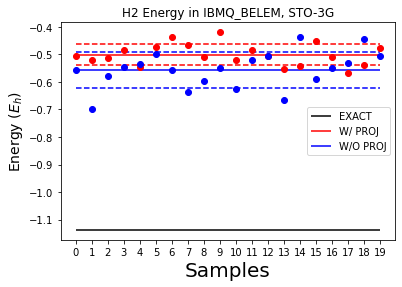

In [192]:
import matplotlib.pyplot as plt



plt.hlines(-1.1372744055294304,0,19,label='EXACT',colors='black')

plt.plot(range(len(Ebins)),Ebins,'or')
plt.hlines(np.average(Ebins),0,19,label='W/ PROJ',colors='red')
plt.hlines(np.average(Ebins)+np.std(Ebins),0,19,linestyles='dashed',colors='red')
plt.hlines(np.average(Ebins)-np.std(Ebins),0,19,linestyles='dashed',colors='red')

plt.plot(range(len(Ebins_np)),Ebins_np,'ob')
plt.hlines(np.average(Ebins_np),0,19,label='W/O PROJ',colors='blue')
plt.hlines(np.average(Ebins_np)+np.std(Ebins_np),0,19,linestyles='dashed',colors='blue')
plt.hlines(np.average(Ebins_np)-np.std(Ebins_np),0,19,linestyles='dashed',colors='blue')

plt.title('H2 Energy in IBMQ_BELEM, STO-3G')
plt.xlabel('Samples',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)
plt.xticks(range(len(Ebins)))
plt.legend(loc='center right')